## Submitted by Mahfooj Ali
## Assignmnet 3

## Importing Libraries

In [25]:

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
import numpy as np


## Data Augmentation and Transforms

In [26]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)



Using device: cuda


##   Load Dataset


In [27]:
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

## Split train into train/validation and  DataLoaders



In [28]:

# Split train into train/validation
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

## dataset insights

In [29]:
image_tensor,label = train_dataset[0]
print( 'values in array for 1 image ',image_tensor)
print( 'Shape of a image tensor ',image_tensor.shape)
print('label of selected image' ,label)

values in array for 1 image  tensor([[[-1.0000, -1.0000, -1.0000,  ..., -0.9529, -0.9529, -1.0000],
         [-0.9529, -0.9529, -0.9529,  ..., -0.9529, -0.9529, -1.0000],
         [-0.9529, -0.9529, -0.9529,  ..., -0.9529, -0.9529, -1.0000],
         ...,
         [-1.0000, -0.3098, -0.3176,  ..., -0.9529, -0.9529, -0.9529],
         [-1.0000, -0.3255, -0.3333,  ..., -0.9529, -0.9529, -0.9529],
         [-1.0000, -0.3176, -0.3569,  ..., -1.0000, -1.0000, -1.0000]],

        [[-1.0000, -1.0000, -1.0000,  ..., -0.9529, -0.9529, -1.0000],
         [-0.9529, -0.9529, -0.9529,  ..., -0.9529, -0.9529, -1.0000],
         [-0.9529, -0.9529, -0.9529,  ..., -0.9529, -0.9529, -1.0000],
         ...,
         [-1.0000, -0.3098, -0.3020,  ..., -0.9529, -0.9529, -0.9529],
         [-1.0000, -0.3176, -0.3333,  ..., -0.9529, -0.9529, -0.9529],
         [-1.0000, -0.3176, -0.3412,  ..., -1.0000, -1.0000, -1.0000]],

        [[-1.0000, -1.0000, -1.0000,  ..., -0.9529, -0.9529, -1.0000],
         [-0.952

 ## Define CNN Model


In [30]:
class AdvancedCNNModel(nn.Module):
    def __init__(self):
        super(AdvancedCNNModel, self).__init__()
        
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, 3, padding=1),  # [64 x 32 x 32]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),  # [64 x 32 x 32]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),              # [64 x 16 x 16]
            nn.Dropout(0.25),
            
            # Block 2
            nn.Conv2d(64, 128, 3, padding=1),  # [128 x 16 x 16]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),  # [128 x 16 x 16]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                # [128 x 8 x 8]
            nn.Dropout(0.25),
            
            # Block 3
            nn.Conv2d(128, 256, 3, padding=1),  # [256 x 8 x 8]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),  # [256 x 8 x 8]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                # [256 x 4 x 4]
            nn.Dropout(0.25),
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 10)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Instantiate the model
model = AdvancedCNNModel().to(device)


##  Training Function


In [31]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


#  Training Function
def train_model(model, train_loader, val_loader, epochs=20):
    train_loss, val_loss = [], []
    train_acc, val_acc = [], []

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = 100. * correct / total
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)

        model.eval()
        running_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_loss.append(running_loss / len(val_loader.dataset))
        val_acc.append(100. * correct / total)

        print(f"Epoch {epoch+1}/{epochs} => Train Acc: {epoch_acc:.2f}%, Val Acc: {val_acc[-1]:.2f}%")

    return train_loss, val_loss, train_acc, val_acc

##  Training the Model


In [32]:
train_loss, val_loss, train_acc, val_acc = train_model(model, train_loader, val_loader, epochs=30)


Epoch 1/30 => Train Acc: 32.46%, Val Acc: 44.82%
Epoch 2/30 => Train Acc: 46.64%, Val Acc: 52.06%
Epoch 3/30 => Train Acc: 52.18%, Val Acc: 59.84%
Epoch 4/30 => Train Acc: 56.36%, Val Acc: 57.96%
Epoch 5/30 => Train Acc: 59.81%, Val Acc: 64.50%
Epoch 6/30 => Train Acc: 62.22%, Val Acc: 62.30%
Epoch 7/30 => Train Acc: 64.74%, Val Acc: 69.58%
Epoch 8/30 => Train Acc: 67.02%, Val Acc: 71.32%
Epoch 9/30 => Train Acc: 68.91%, Val Acc: 72.68%
Epoch 10/30 => Train Acc: 70.59%, Val Acc: 73.68%
Epoch 11/30 => Train Acc: 72.13%, Val Acc: 75.80%
Epoch 12/30 => Train Acc: 73.73%, Val Acc: 75.80%
Epoch 13/30 => Train Acc: 74.80%, Val Acc: 75.66%
Epoch 14/30 => Train Acc: 76.04%, Val Acc: 78.30%
Epoch 15/30 => Train Acc: 76.60%, Val Acc: 78.88%
Epoch 16/30 => Train Acc: 77.70%, Val Acc: 79.02%
Epoch 17/30 => Train Acc: 78.32%, Val Acc: 81.18%
Epoch 18/30 => Train Acc: 79.26%, Val Acc: 80.94%
Epoch 19/30 => Train Acc: 79.79%, Val Acc: 81.12%
Epoch 20/30 => Train Acc: 80.37%, Val Acc: 82.20%
Epoch 21/

#  Plot Loss and Accuracy


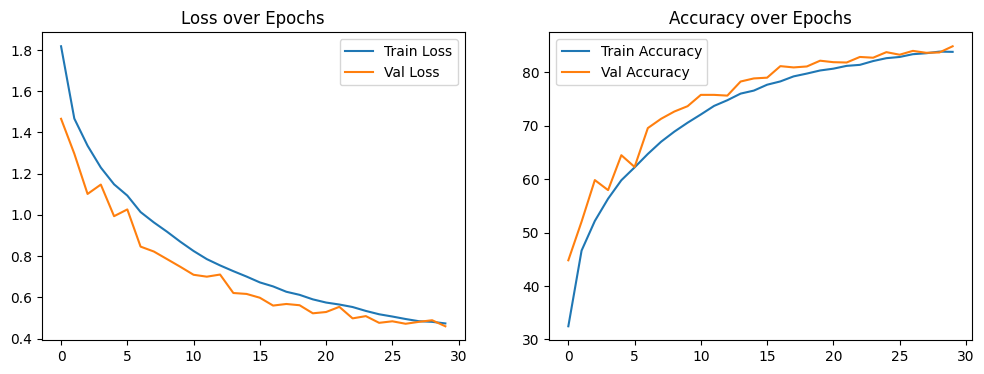

In [33]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Val Loss")
plt.title("Loss over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label="Train Accuracy")
plt.plot(val_acc, label="Val Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()
plt.show()


## Evaluate on Test Set


In [34]:
def evaluate_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    print(f"Test Accuracy: {100. * correct / total:.2f}%")

evaluate_model(model, test_loader)


Test Accuracy: 87.37%


## Save the Model


In [36]:
torch.save(model.state_dict(), "model.pth")
print("Model saved as model.pth")

Model saved as model.pth
